In [119]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [120]:
data = pd.read_csv("../datasets/sms-classification/spam.csv", encoding="latin-1")
data = data.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1);
data = data.rename(index=str, columns={"v1":"label","v2":"text"});
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [121]:
train, test = train_test_split(data, test_size=0.2, random_state=42);
train.reset_index(drop=True), test.reset_index(drop=True)

(     label                                               text
 0      ham  No I'm in the same boat. Still here at my moms...
 1     spam  (Bank of Granite issues Strong-Buy) EXPLOSIVE ...
 2      ham     They r giving a second chance to rahul dengra.
 3      ham     O i played smash bros  &lt;#&gt;  religiously.
 4     spam  PRIVATE! Your 2003 Account Statement for 07973...
 ...    ...                                                ...
 4452   ham  I came hostel. I m going to sleep. Plz call me...
 4453   ham                             Sorry, I'll call later
 4454   ham      Prabha..i'm soryda..realy..frm heart i'm sory
 4455   ham                         Nt joking seriously i told
 4456   ham                In work now. Going have in few min.
 
 [4457 rows x 2 columns],
      label                                               text
 0      ham  Funny fact Nobody teaches volcanoes 2 erupt, t...
 1      ham  I sent my scores to sophas and i had to do sec...
 2     spam  We know someon

In [122]:
train.to_csv("../datasets/sms-classification/spam_train.csv", index=False);
test.to_csv("../datasets/sms-classification/spam_test.csv", index=False);

In [123]:
import numpy as np
import torch
from torchtext.data import Field, LabelField, TabularDataset, BucketIterator

In [124]:
import nltk
nltk.download("punkt");
from nltk import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [125]:
Text = Field(tokenize=word_tokenize);
Label = LabelField(dtype=torch.float);
datafields = [("label",Label), ("text",Text)];
trn, tst = TabularDataset.splits(path="../datasets/sms-classification",
                                train = "spam_train.csv",
                                test = "spam_test.csv",
                                format = "csv",
                                skip_header = True,
                                fields = datafields);
Text.build_vocab(trn, max_size=10000);
vocab_size = len(Text.vocab);
Label.build_vocab(trn);

In [126]:
Text.vocab.freqs.most_common(10)

[('.', 3847),
 ('to', 1750),
 ('I', 1574),
 (',', 1468),
 ('you', 1462),
 ('?', 1256),
 ('!', 1134),
 ('a', 1068),
 ('the', 946),
 ('...', 923)]

In [127]:
print(Text.vocab.itos[0:10])

['<unk>', '<pad>', '.', 'to', 'I', ',', 'you', '?', '!', 'a']


In [128]:
print(Label.vocab.stoi)

defaultdict(None, {'ham': 0, 'spam': 1})


In [129]:
batch_size = 32;
train_itr, test_itr = BucketIterator.splits((trn, tst),
                                            batch_size = batch_size,
                                            sort_key = lambda x: len(x.text),
                                            #sort=False,
                                            #shuffle=True,
                                            sort_within_batch=False);

In [130]:
import torch.nn as nn
class SMSClassifierModel(nn.Module):
    
    def __init__(self, vocab_size):
        super().__init__();
        self.model_input = nn.Embedding(vocab_size, 100);
        # self.rnn = nn.RNN(100, 128);
        self.rnn = nn.LSTM(100, 128);
        self.model_output = nn.Linear(128, 1);
        self.activation = nn.Sigmoid()
        
    def forward(self, sms_text):
        embedded = self.model_input(sms_text);
        # _,hidden = self.rnn(embedded);
        _,(hidden,_) = self.rnn(embedded);
        output = self.model_output(hidden);
        return self.activation(output)

In [131]:
from tqdm import tqdm
import torch.optim as optim
n_epochs = 10;
sms_classifier = SMSClassifierModel(vocab_size);
optimizer = optim.Adam(sms_classifier.parameters(), lr=1e-4);
loss_function = nn.BCELoss();

loss_stats = []
acc_stats = []
val_loss_stats = []
val_acc_stats = []
for epoch in range(n_epochs):
    # Train
    sms_classifier.train();
    epoch_acc = 0;
    epoch_loss = 0;
    for batch in tqdm(train_itr):
        optimizer.zero_grad();
        pred = sms_classifier(batch.text).squeeze();
        loss = loss_function(pred, batch.label)
        rounded_pred = torch.round(pred);
        correct = rounded_pred == batch.label;
        acc = sum(correct.float())*100/len(correct);
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item();
        epoch_acc += acc.item();  
    epoch_loss = epoch_loss/len(train_itr)
    epoch_acc = epoch_acc/len(train_itr)
    loss_stats.append(epoch_loss)
    acc_stats.append(epoch_acc)
    
    # Validate
    sms_classifier.eval();
    val_loss = 0;
    val_acc = 0;
    with torch.no_grad():        
        for batch in test_itr:
            pred = sms_classifier(batch.text).squeeze();
            loss = loss_function(pred, batch.label)
            rounded_pred = torch.round(pred);
            correct = rounded_pred == batch.label;
            acc = sum(correct.float())*100/len(correct);
            val_loss += loss.item();
            val_acc += acc.item();
    val_loss = val_loss/len(test_itr)
    val_acc = val_acc/len(test_itr)
    val_loss_stats.append(val_loss)
    val_acc_stats.append(val_acc)
    
    print("Epoch:", epoch+1, ", Loss:", epoch_loss, ", Accuracy:", epoch_acc, "%", ", Val Loss:", val_loss, ", Val Accuracy:", val_acc,"%");

100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:19<00:00,  7.22it/s]


Epoch: 1 , Loss: 0.4247988076082298 , Accuracy: 86.40625 % , Val Loss: 0.5908270631517683 , Val Accuracy: 77.58928571428571 %


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:19<00:00,  7.16it/s]


Epoch: 2 , Loss: 0.3982403790312154 , Accuracy: 86.50545632498604 % , Val Loss: 0.5682667332036154 , Val Accuracy: 81.69642857142857 %


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:19<00:00,  7.24it/s]


Epoch: 3 , Loss: 0.3877196018184934 , Accuracy: 86.60714285714286 % , Val Loss: 0.5584362010870662 , Val Accuracy: 83.66071428571429 %


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:19<00:00,  7.23it/s]


Epoch: 4 , Loss: 0.37588110246828627 , Accuracy: 86.65178571428571 % , Val Loss: 0.5481287262269429 , Val Accuracy: 86.07142857142857 %


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:18<00:00,  7.44it/s]


Epoch: 5 , Loss: 0.3581527215029512 , Accuracy: 86.20287699018206 % , Val Loss: 0.533317608492715 , Val Accuracy: 87.14285714285714 %


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:18<00:00,  7.41it/s]


Epoch: 6 , Loss: 0.2976589519530535 , Accuracy: 88.20188489641463 % , Val Loss: 0.4946149230003357 , Val Accuracy: 88.48214285714286 %


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:19<00:00,  7.01it/s]


Epoch: 7 , Loss: 0.23740210075463566 , Accuracy: 91.41617061070033 % , Val Loss: 0.44313239359429907 , Val Accuracy: 90.26785714285714 %


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:18<00:00,  7.39it/s]


Epoch: 8 , Loss: 0.22719348392316274 , Accuracy: 91.65178571428571 % , Val Loss: 0.41777458488941194 , Val Accuracy: 90.89285714285714 %


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:19<00:00,  7.32it/s]


Epoch: 9 , Loss: 0.19207591717796665 , Accuracy: 93.63591270446777 % , Val Loss: 0.3953226967049496 , Val Accuracy: 92.58928571428571 %


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:19<00:00,  7.33it/s]


Epoch: 10 , Loss: 0.15782641844291773 , Accuracy: 95.04216270446777 % , Val Loss: 0.38704209114824023 , Val Accuracy: 93.2870370047433 %


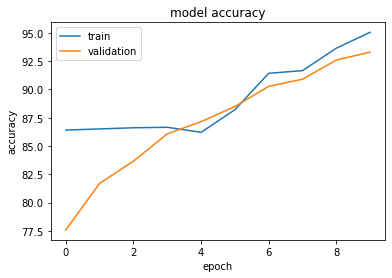

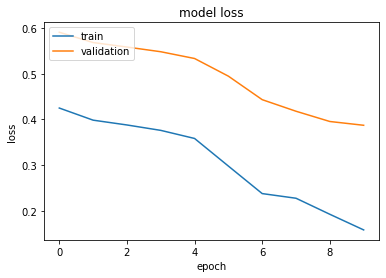

In [132]:
import matplotlib.pyplot as plt

plt.plot(acc_stats)
plt.plot(val_acc_stats)

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
# plt.ylim(0.5,1)
plt.show()

plt.plot(loss_stats)
plt.plot(val_loss_stats)

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
# plt.ylim(0,1.5)
plt.show()

In [133]:
print(sms_classifier);

SMSClassifierModel(
  (model_input): Embedding(10002, 100)
  (rnn): LSTM(100, 128)
  (model_output): Linear(in_features=128, out_features=1, bias=True)
  (activation): Sigmoid()
)


In [134]:
torch.save(sms_classifier.state_dict(), 'sms_classifier_weights.pt');
import pickle
output = open('sms_vocab.pkl', 'wb')
pickle.dump(Text.vocab, output)
output.close()